# <center> Decision Trees on Amazon Fine Food Reviews Dataset </center>
___

###  <b>Exercise</b> :

1.	Download Amazon Fine Food Reviews dataset from Kaggle. You may have to create a Kaggle account to download data. (https://www.kaggle.com/snap/amazon-fine-food-reviews)
2.	Split data into train and test using time based slicing as 70%  train & 30% test.
3.	Perform featurization Avg Word2Vec, tf-idf-Word2Vec.
4.	Apply GridsearchCV on train data to find optimal depth.
5.	Also plot depth values vs error.
6.	Apply Decision Tree on dataset.
7.	To test the performance of the model, calculate test error, train error, accuracy,precision,recall,F1-score,confusion matrix(TPR,TNR,FPR,FNR)
8.	Write your observations in English as crisply and unambiguously as possible. Always quantify your results.



### Information regarding data set :

1. <b>Title</b>: Amazon Fine Food Reviews Data

2. <b>Sources</b>: Stanford Network Analysis Project(SNAP)

3. <b>Relevant Information</b>: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~568,454 reviews up to October 2012(Oct 1999 - Oct 2012). Reviews include product and user information, ratings, and a plain text review.
4.  <b>Attribute Information</b>:   
    <b>ProductId </b>- unique identifier for the product <br/>
    <b>UserId </b>- unqiue identifier for the user <br/>
    <b>ProfileName </b>- name of the user <br/>
    <b>HelpfulnessNumerator </b>- number of users who found the review helpful <br/>
    <b>HelpfulnessDenominator </b>- number of users who indicated whether they found the review helpful or not <br/>
    <b>Score </b>- rating between 1 and 5.( rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored) <br/>
    <b>Time </b>- timestamp for the review <br/> 
    <b>Summary </b>- brief summary of the review <br/>
    <b>Text </b>- text of the review <br/>

---

### <b>Objective :</b> 
> <span style="color:blue">It is a 2-class classification task, where we have to analyze, transform(Avg Word2ec and TFIDF Word2Vec) and find a separating decision surface, which can evaluate whether a review is positive or negative.<span>

---


In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

import traceback
import sqlite3
import itertools
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier

### (1) Load dataset :

Dataset Shape : 
 (351237, 11)

Column Names: 
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

Target Class label : 
positive    297807
negative     53430
Name: Score, dtype: int64



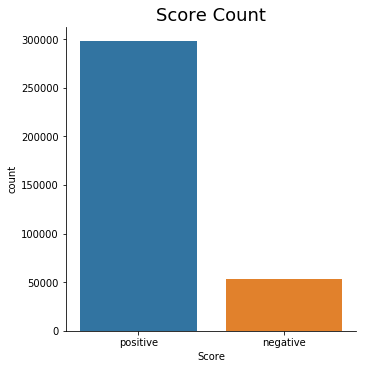

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
382,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02 05:30:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
250,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06 05:30:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
383,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03 05:30:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
269,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,2000-01-09 05:30:00,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
369,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,2000-01-19 05:30:00,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...


In [3]:
# This dataset is already gone through data deduplication and text preprocessing, so it is approx ~364K

# For Data Cleaning Steps follow this link -
# ipython notebook - https://drive.google.com/open?id=1JXCva5vXdIPgHbfNdD9sgnySqELoVtpy
# dataset - https://drive.google.com/open?id=1IoDoTT8TfDu53N6cyKg6xVCU-FDPHyIF

# For Text Preporcessing Steps follow this link -
# ipython notebook - https://drive.google.com/open?id=18-AkTzzEhCwM_hflIbDNBMAP-imX4k4i
# dataset - https://drive.google.com/open?id=1SfDwwXFhDpjgtfIE5O_E80SO89xRc8Sa

# Load dataset
def load_review_dataset():
    # Create connection object to load sqlite dataset
    connection = sqlite3.connect('finalDataSet.sqlite')

    # Load data into pandas dataframe.
    reviews_df = pd.read_sql_query(""" SELECT * FROM Reviews """,connection)

    # Drop index column 
    reviews_df = reviews_df.drop(columns=['index'])
    
    # Take sample of reviews   
    # reviews_df = reviews_df.sample(100000)
        
    # Convert timestamp to datetime.
    reviews_df['Time'] = reviews_df[['Time']].applymap(lambda x: dt.datetime.fromtimestamp(x))

    # Sort the data on the basis of time.
    reviews_df = reviews_df.sort_values(by=['Time'])

    print("Dataset Shape : \n",reviews_df.shape)
    print("\nColumn Names: \n",reviews_df.columns)
    print("\nTarget Class label : ")
    print(reviews_df['Score'].value_counts())
    print()   
    
    return reviews_df


# Load 'finalDataSet.sqlite' in panda's daraframe.
reviews_df = load_review_dataset()

# Split data into train and test
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(reviews_df['CleanedText'].values,
                                                    reviews_df['Score'].values,
                                                    test_size=0.3,
                                                    shuffle=False,
                                                    random_state=0)

# Plot score
sn.catplot(x ="Score",kind='count',data=reviews_df,height=5)
plt.title("Score Count", fontsize=18)
plt.show()
reviews_df.head()

In [4]:
###--- All utility variables and functions(After importing all the necessary packages, always run this cell first.) ---###

# hyperparameter depth
list_depth = []

# Training Error
train_error = []

# Test Error
test_error = []


def plot_report_confusion_matrix(confusion_matrix, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):    
    plt.figure()
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    TN = confusion_matrix[0,0]       
    FP = confusion_matrix[0,1]  
    FN = confusion_matrix[1,0]
    TP = confusion_matrix[1,1]
    

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    
    # Specificity or true negative rate
    TNR = TN/(TN+FP)  
    
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    
    # False negative rate
    FNR = FN/(TP+FN)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    print()
    # Pretty table instance
    ptable = PrettyTable()
    ptable.title = "Confusion Matrix Report"
    ptable.field_names = ['Term','Value']
    ptable.add_row(["TP (True Positive)",TP])
    ptable.add_row(["TN (True Negative)",TN])
    ptable.add_row(["FP (False Positive)",FP])
    ptable.add_row(["FN (False Negative)",FN])
    ptable.add_row(["TPR (True Positive Rate)= TP/(TP+FN))","{0:.2f}".format(TPR)])
    ptable.add_row(["TNR (True Negative Rate)= TN/(TN+FP))","{0:.2f}".format(TNR)])
    ptable.add_row(["FPR (False Positive Rate)= FP/(FP+TN))","{0:.2f}".format(FPR)])
    ptable.add_row(["FNR (False Negative Rate)= FN/(TP+FN))","{0:.2f}".format(FNR)])
    ptable.add_row(["ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN))","{0:.2f}%".format(ACC*100)])
    
    # Print pretty table values
    print(ptable)
    

def performance_measure(classifier,x_train,x_test,y_train,y_test):
    print("-------------------------- {0} --------------------------".format(type(classifier).__name__))           
            
    # Predict target class label
    predicted_y_test = classifier.predict(x_test)
    
    # Predict train class label
    predicted_y_train = classifier.predict(x_train)
            
    ptable = PrettyTable()
    ptable.title = "GridSearchCV"
                    
    ptable.field_names = ["Hyperparameter (depth)","Scoring","Mean","Variance"]

    list_means = classifier.cv_results_['mean_test_score']
    list_stds = classifier.cv_results_['std_test_score']
    list_params = classifier.cv_results_['params']
    scores = dict()       
    for mean, std, params in zip(list_means, list_stds, list_params):
        scores[params['max_depth']] = "{0:.2f}".format(1 - mean)
        ptable.add_row([params['max_depth'],"Accuracy", "{0:.2f}".format(mean), "{0:.2f}".format(std*2)])
               
    print()
    plt.plot(scores.keys(),scores.values())
    plt.gca().invert_yaxis()
    plt.xlabel("Depth Values")
    plt.ylabel("Error Values")
    plt.show()
    print()
            
    print()
    print(ptable)
    print()

    optimal_depth = classifier.best_params_['max_depth']    
    train_accuracy = accuracy_score(Y_TRAIN, predicted_y_train)
    test_accuracy = accuracy_score(Y_TEST, predicted_y_test)
    
    list_depth.append(optimal_depth)  
    
    test_error.append(1 - test_accuracy)
    train_error.append(1 - train_accuracy)    
             
    # Print Optimal hyperparameter and corresponding accuracy
    ptable = PrettyTable()
    ptable.title = "Optimal depth & Testing accuracy score"
    ptable.field_names=["Cross Validation","Depth value","Accuracy(%)"]
    ptable.add_row([type(classifier).__name__ ,optimal_depth,"{0:.2f}".format(test_accuracy*100)])
    print(ptable)  
            
    # Print classification report
    print()          
    ptable = PrettyTable()
    ptable.title = "Classification report with depth value = {0}".format(optimal_depth)
    ptable.field_names = ["Class Lable/Averages","Precision", "Recall","F1-Score","Support"]
    report_dict = classification_report(Y_TEST, predicted_y_test,output_dict = True)
    for key , value in report_dict.items():        
        inner_dict = value        
        ptable.add_row([key,
                        "{0:.2f}".format(inner_dict['precision']),
                        "{0:.2f}".format(inner_dict['recall']),
                        "{0:.2f}".format(inner_dict['f1-score']),
                        "{0:.2f}".format(inner_dict['support'])])
            
    print(ptable)
           
    # Calculate and plot confusion matrix
    cnf_mat = confusion_matrix(Y_TEST, predicted_y_test)            
    plot_report_confusion_matrix(cnf_mat, classes=["negative", "positive"],title='Confusion Matrix')
    print()        
    print()
    
    
def conclude():
    ptable=PrettyTable()
    ptable.title = "***Conclusion***"
    ptable.field_names=["CV","Model","Hyperparameter 'depth'","Train Error","Test Error"]
    
    ptable.add_row(["GridSearchCV",
                    "BOW:Decision Tree",
                    list_depth[0],                    
                    str(round(train_error[0], 2)*100)+"%",
                    str(round(test_error[0], 2)*100)+"%"]) 

    ptable.add_row(["GridSearchCV",
                    "TFIDF:Decision Tree",
                    list_depth[1],                    
                    str(round(train_error[1], 2)*100)+"%",
                    str(round(test_error[1], 2)*100)+"%"]) 

    ptable.add_row(["GridSearchCV",
                    "AVG-WORD2VEC:Decision Tree",
                    list_depth[2],                    
                    str(round(train_error[2], 2)*100)+"%",
                    str(round(test_error[2], 2)*100)+"%"])  
                        
    ptable.add_row(["GridSearchCV",
                    "TFIDF-WORD2VEC:RBF-SVC",
                    list_depth[3],                   
                    str(round(train_error[3], 2)*100)+"%",
                    str(round(test_error[3], 2)*100)+"%"])

    print(ptable)

<br/><br/>

### (2) Convert review text to vector representation :

In [5]:
# Hyperparameter max depth and min sample split
parameters = {'max_depth':range(3, 10)}

#### (2.1) Bag of Words (BoW) :

In [6]:
%%time

# Instantiate CountVectorizer
bow_count_vectorizer = CountVectorizer()

# Tokenize and build vocab
bow_count_vectorizer.fit(X_TRAIN)

# Encode document
x_train_matrix = bow_count_vectorizer.transform(X_TRAIN)
x_test_matrix = bow_count_vectorizer.transform(X_TEST)

print("\nThe type of count vectorizer ",type(x_train_matrix))
print("The shape of train matrix ",x_train_matrix.get_shape())
print("The number of unique words in train matrix ", x_train_matrix.get_shape()[1])



The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train matrix  (245865, 74398)
The number of unique words in train matrix  74398
Wall time: 14.7 s


-------------------------- GridSearchCV --------------------------



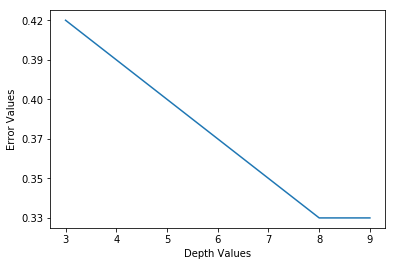



+-----------------------------------------------------+
|                     GridSearchCV                    |
+------------------------+----------+------+----------+
| Hyperparameter (depth) | Scoring  | Mean | Variance |
+------------------------+----------+------+----------+
|           3            | Accuracy | 0.58 |   0.01   |
|           4            | Accuracy | 0.61 |   0.01   |
|           5            | Accuracy | 0.60 |   0.02   |
|           6            | Accuracy | 0.63 |   0.01   |
|           7            | Accuracy | 0.65 |   0.01   |
|           8            | Accuracy | 0.67 |   0.02   |
|           9            | Accuracy | 0.67 |   0.01   |
+------------------------+----------+------+----------+

+----------------------------------------------+
|    Optimal depth & Testing accuracy score    |
+------------------+-------------+-------------+
| Cross Validation | Depth value | Accuracy(%) |
+------------------+-------------+-------------+
|   GridSearchCV   |    

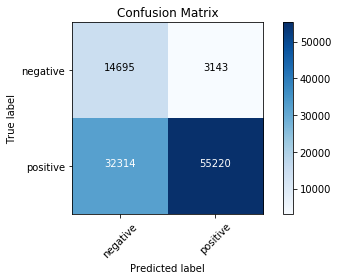


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 55220  |
|           TN (True Negative)           | 14695  |
|          FP (False Positive)           |  3143  |
|          FN (False Negative)           | 32314  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.63  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.82  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.18  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.37  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 66.35% |
+----------------------------------------+--------+




In [7]:
# Instantiate decision tree.
dt_estimator = DecisionTreeClassifier(min_samples_split = 4,
                                      class_weight = "balanced")

# Grid search cross Validation on average word2vec
gscv = GridSearchCV(dt_estimator,
                    scoring="accuracy",
                    param_grid=parameters,
                    cv = TimeSeriesSplit(n_splits=10),                    
                    n_jobs=-1)

# Fit the model
gscv.fit(x_train_matrix,Y_TRAIN)

# Perform performance meausre,plot and draw reports.
performance_measure(gscv,x_train_matrix,x_test_matrix,Y_TRAIN,Y_TEST)

#### (2.2) Term Frequency - Inverse Document Frequency (TF-IDF) :

In [8]:
%%time

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

# Tokenize and build vocab
tfidf_vectorizer.fit(X_TRAIN)

# Encode document
x_train_matrix = tfidf_vectorizer.transform(X_TRAIN)
x_test_matrix = tfidf_vectorizer.transform(X_TEST)

print("\nThe type of count vectorizer ",type(x_train_matrix))
print("The shape of train matrix ",x_train_matrix.get_shape())
print("The number of unique words in train matrix ", x_train_matrix.get_shape()[1])


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train matrix  (245865, 487621)
The number of unique words in train matrix  487621
Wall time: 44.9 s


-------------------------- GridSearchCV --------------------------



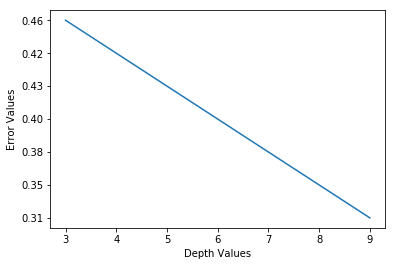



+-----------------------------------------------------+
|                     GridSearchCV                    |
+------------------------+----------+------+----------+
| Hyperparameter (depth) | Scoring  | Mean | Variance |
+------------------------+----------+------+----------+
|           3            | Accuracy | 0.54 |   0.03   |
|           4            | Accuracy | 0.58 |   0.02   |
|           5            | Accuracy | 0.57 |   0.02   |
|           6            | Accuracy | 0.60 |   0.02   |
|           7            | Accuracy | 0.62 |   0.03   |
|           8            | Accuracy | 0.65 |   0.05   |
|           9            | Accuracy | 0.69 |   0.02   |
+------------------------+----------+------+----------+

+----------------------------------------------+
|    Optimal depth & Testing accuracy score    |
+------------------+-------------+-------------+
| Cross Validation | Depth value | Accuracy(%) |
+------------------+-------------+-------------+
|   GridSearchCV   |    

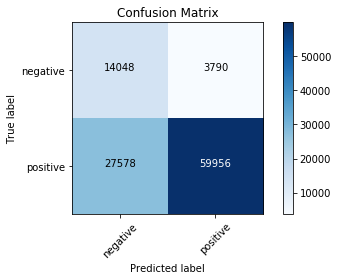


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 59956  |
|           TN (True Negative)           | 14048  |
|          FP (False Positive)           |  3790  |
|          FN (False Negative)           | 27578  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.68  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.79  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.21  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.32  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 70.23% |
+----------------------------------------+--------+




In [9]:
# Instantiate decision tree.
dt_estimator = DecisionTreeClassifier(min_samples_split = 4,
                                      class_weight = "balanced")


# Grid search cross Validation on average word2vec
gscv = GridSearchCV(dt_estimator,
                    scoring="accuracy",
                    param_grid=parameters,
                    cv = TimeSeriesSplit(n_splits=10),                   
                    n_jobs=-1)

# Fit the model
gscv.fit(x_train_matrix,Y_TRAIN)

# Perform performance meausre,plot and draw reports.
performance_measure(gscv,x_train_matrix,x_test_matrix,Y_TRAIN,Y_TEST)

#### (2.3) Average Word2Vec :

In [10]:
%%time

# Create our own Word2Vec model from training data.
        
# Make list of list from training data
list_of_sentences_in_train=[]
for sentence in X_TRAIN:
    list_of_sentences_in_train.append(sentence.split())
            
# Make list of list from testing data - this will be useful when vectorizing testing data.
list_of_sentences_in_test=[]
for sentence in X_TEST:
    list_of_sentences_in_test.append(sentence.split())
            
print("Shape of training data : ",X_TRAIN.shape)
print("Shape of testing data : ",X_TEST.shape)
print("Number of sentences present in training data : ",len(list_of_sentences_in_train))
print("Number of sentences present in testing data : ",len(list_of_sentences_in_test))
        
# Generate model
w2v_model = Word2Vec(list_of_sentences_in_train,min_count=3,size=300, workers=6)
        
# List of word in vocabulary 
w2v_words = list(w2v_model.wv.vocab)
print("Length of vocabulary : ",len(w2v_words))

# Prepare train vectorizer using trained word2vec model
train_list = []
for sentence in tqdm(list_of_sentences_in_train,unit=" sentence",desc='Average Word2Vec - Train data'):
    word_2_vec = np.zeros(300)
    cnt_words = 0
    for word in sentence:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            word_2_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        word_2_vec /= cnt_words
    train_list.append(word_2_vec)
        
# Prepare test vectorizer using trained word2vec model
test_list = []
for sentence in tqdm(list_of_sentences_in_test,unit=" sentence",desc='Average Word2Vec - Test data'):
    word_2_vec = np.zeros(300)
    cnt_words = 0
    for word in sentence:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            word_2_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        word_2_vec /= cnt_words
    test_list.append(word_2_vec)
            
avg_w2v_train = np.array(train_list)
avg_w2v_test = np.array(test_list)
           

print("\nShape of training vectorizer : ",avg_w2v_train.shape)
print("Shape of testing vectorizer : ",avg_w2v_test.shape)

Shape of training data :  (245865,)
Shape of testing data :  (105372,)
Number of sentences present in training data :  245865
Number of sentences present in testing data :  105372
Length of vocabulary :  24460


Average Word2Vec - Test data: 100%|████████████████████████████████████| 105372/105372 [02:04<00:00, 843.22 sentence/s]



Shape of training vectorizer :  (245865, 300)
Shape of testing vectorizer :  (105372, 300)
Wall time: 6min 59s


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  7.4min finished


-------------------------- GridSearchCV --------------------------



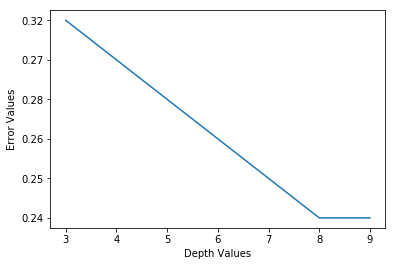



+-----------------------------------------------------+
|                     GridSearchCV                    |
+------------------------+----------+------+----------+
| Hyperparameter (depth) | Scoring  | Mean | Variance |
+------------------------+----------+------+----------+
|           3            | Accuracy | 0.68 |   0.03   |
|           4            | Accuracy | 0.73 |   0.05   |
|           5            | Accuracy | 0.72 |   0.03   |
|           6            | Accuracy | 0.74 |   0.01   |
|           7            | Accuracy | 0.75 |   0.02   |
|           8            | Accuracy | 0.76 |   0.01   |
|           9            | Accuracy | 0.76 |   0.02   |
+------------------------+----------+------+----------+

+----------------------------------------------+
|    Optimal depth & Testing accuracy score    |
+------------------+-------------+-------------+
| Cross Validation | Depth value | Accuracy(%) |
+------------------+-------------+-------------+
|   GridSearchCV   |    

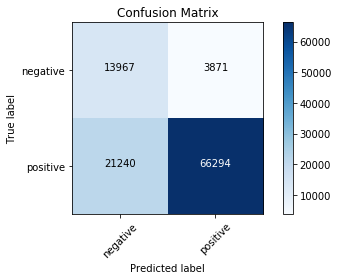


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 66294  |
|           TN (True Negative)           | 13967  |
|          FP (False Positive)           |  3871  |
|          FN (False Negative)           | 21240  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.76  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.78  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.22  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.24  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 76.17% |
+----------------------------------------+--------+


Wall time: 8min 43s


In [11]:
%%time

# Instantiate decision tree.
dt_estimator = DecisionTreeClassifier(min_samples_split = 4,
                                      class_weight = "balanced")


# Grid search cross Validation on average word2vec
gscv = GridSearchCV(dt_estimator,
                    scoring="accuracy",
                    param_grid=parameters,
                    cv = TimeSeriesSplit(n_splits=10),                    
                    verbose=1,
                    n_jobs=-1)

# Fit the model
gscv.fit(avg_w2v_train,Y_TRAIN)

# Perform performance meausre,plot and draw reports.
performance_measure(gscv,avg_w2v_train,avg_w2v_test,Y_TRAIN,Y_TEST)

#### (2.4) Term Frequency - Inverse Document Frequency Weighted Word2Vec(TF-IDF Word2Vec) :

In [12]:
%%time

# Make list of list from training data.      
sentences_in_train=[]
for sentence in X_TRAIN:
    sentences_in_train.append(sentence.split())

# Make list of list from testing data - this will be useful when vectorizing testing data.
sentences_in_test=[]
for sentence in X_TEST:
    sentences_in_test.append(sentence.split())
            
# Generate model
w2v_model = Word2Vec(sentences_in_train,min_count=3,size=300, workers=6)

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

# Tokenize and build vocab
tfidf_vectorizer.fit(X_TRAIN)

# Encode document
x_train_matrix = tfidf_vectorizer.transform(X_TRAIN)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names()

# Dictionary with word as a key, and the idf as a value
dict_word_idf = dict(zip(feature_names, list(tfidf_vectorizer.idf_)))

# Prepare train vectorizer using trained word2vec model        
train_list = []
row = 0
for sentence in tqdm(sentences_in_train,unit=" sentence",desc='TF-IDF Weighted Word2Vec - Train data'):
    word_2_vec = np.zeros(300)
    weight_tfidf_sum = 0
    for word in sentence:
        try:
            vec = w2v_model.wv[word]
            # dict_word_idf[word] = idf value of word in whole courpus
            # sentence.count(word) = tf valeus of word in this review
            tfidf_value =  dict_word_idf[word]*sentence.count(word)
            word_2_vec += (vec * tfidf_value)
            weight_tfidf_sum += tfidf_value
        except:
            pass
    if weight_tfidf_sum != 0:
        word_2_vec /= weight_tfidf_sum
    train_list.append(word_2_vec)
    row += 1
        
# Prepare test vectorizer using trained word2vec model
test_list = []
row = 0
for sentence in tqdm(sentences_in_test, unit=" sentence",desc='TF-IDF Weighted Word2Vec - Test data'):
    word_2_vec = np.zeros(300)
    weight_tfidf_sum = 0
    for word in sentence:
        try:
            vec = w2v_model.wv[word]
            # dict_word_idf[word] = idf value of word in whole courpus
            # sentence.count(word) = tf valeus of word in this review
            tfidf_value =  dict_word_idf[word]*sentence.count(word)
            word_2_vec += (vec * tfidf_value)
            weight_tfidf_sum += tfidf_value
        except:
            pass
    if weight_tfidf_sum != 0:
        word_2_vec /= weight_tfidf_sum
    test_list.append(word_2_vec)
    row += 1
        
tfidf_w2v_train = np.array(train_list)
tfidf_w2v_test = np.array(test_list)


print("\nShape of training vectorizer : ",tfidf_w2v_train.shape)
print("Shape of testing vectorizer : ",tfidf_w2v_test.shape)

TF-IDF Weighted Word2Vec - Test data: 100%|███████████████████████████| 105372/105372 [00:29<00:00, 3607.42 sentence/s]



Shape of training vectorizer :  (245865, 300)
Shape of testing vectorizer :  (105372, 300)
Wall time: 2min 37s


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  7.8min finished


-------------------------- GridSearchCV --------------------------



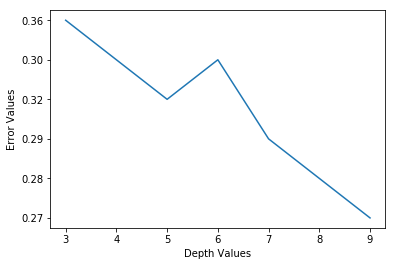



+-----------------------------------------------------+
|                     GridSearchCV                    |
+------------------------+----------+------+----------+
| Hyperparameter (depth) | Scoring  | Mean | Variance |
+------------------------+----------+------+----------+
|           3            | Accuracy | 0.64 |   0.06   |
|           4            | Accuracy | 0.70 |   0.03   |
|           5            | Accuracy | 0.68 |   0.03   |
|           6            | Accuracy | 0.70 |   0.03   |
|           7            | Accuracy | 0.71 |   0.02   |
|           8            | Accuracy | 0.72 |   0.02   |
|           9            | Accuracy | 0.73 |   0.04   |
+------------------------+----------+------+----------+

+----------------------------------------------+
|    Optimal depth & Testing accuracy score    |
+------------------+-------------+-------------+
| Cross Validation | Depth value | Accuracy(%) |
+------------------+-------------+-------------+
|   GridSearchCV   |    

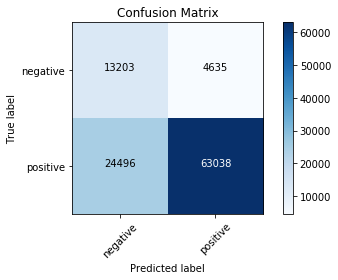


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 63038  |
|           TN (True Negative)           | 13203  |
|          FP (False Positive)           |  4635  |
|          FN (False Negative)           | 24496  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.72  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.74  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.26  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.28  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 72.35% |
+----------------------------------------+--------+


Wall time: 9min 17s


In [13]:
%%time

# Instantiate decision tree.
dt_estimator = DecisionTreeClassifier(min_samples_split = 4,
                                      class_weight = "balanced")


# Grid search cross Validation on tfidf weighted word2vec
gscv = GridSearchCV(dt_estimator,
                    scoring="accuracy",
                    param_grid=parameters,
                    cv = TimeSeriesSplit(n_splits=10),                    
                    verbose=1,
                    n_jobs=-1)

# Fit the model
gscv.fit(tfidf_w2v_train,Y_TRAIN)

# Perform performance meausre,plot and draw reports.
performance_measure(gscv,tfidf_w2v_train,tfidf_w2v_test,Y_TRAIN,Y_TEST)

<br/><br/>

---
### Conclusion :
---

In [14]:
conclude()

+--------------------------------------------------------------------------------------------------------+
|                                            ***Conclusion***                                            |
+--------------+----------------------------+------------------------+-------------+---------------------+
|      CV      |           Model            | Hyperparameter 'depth' | Train Error |      Test Error     |
+--------------+----------------------------+------------------------+-------------+---------------------+
| GridSearchCV |     BOW:Decision Tree      |           9            |    33.0%    |        34.0%        |
| GridSearchCV |    TFIDF:Decision Tree     |           9            |    30.0%    |        30.0%        |
| GridSearchCV | AVG-WORD2VEC:Decision Tree |           9            |    21.0%    |        24.0%        |
| GridSearchCV |   TFIDF-WORD2VEC:RBF-SVC   |           9            |    25.0%    | 28.000000000000004% |
+--------------+---------------------

---
### Observations :
---

> 1. Here, desicison tree is applied on amazon fine food review dataset with time series splitting(~364K).
> 2. Given dataset is imbalanced in nature (postive reviews:negative reviews = 5.57/1).
> 3. Grid search 10-fold technique is applied to calculate optimal hyperparameter 'max_depth'.
> 4. Decision tree does not perform well with text vectors,as you can see the accuracy in the conclusion table.
> 5. We can increase the accuracy by incrasing the max_depth value, but that is not recommended, becsuse high max_deth value will force data to overfit.
> 6. As you increase the range of max_depth, it will overfit and will become prone to outliers, so thats why we have taken range from 3 to 9.
> 7. To manitain bias-variance tradeoff, we can stick with the same hyperpaameter value that we have calculated.
> 8. for more information you can always refer to conclusion table above.